# CVPR22-Fact: ステップ実行トレーニングノートブック

このノートブックは学習の各ステップ（設定→データ→モデル→最適化→1エポック学習→評価→保存→プロトタイプ置換→増分準備）を1セルずつ実行できるように構成しています。


In [11]:
# 設定（Makefile相当）
import os, sys
import torch
from utils import set_seed
PROJECT_ROOT = '/home/hawk/Documents/school/test/CVPR22-Fact'
sys.path.append(PROJECT_ROOT)

MAKE = {
    'DATASET': 'cicids2017_improved',
    'DATAROOT': 'data',
    'EPOCHS_BASE': 1,
    'EPOCHS_NEW': 1,
    'SESSIONS': 7,
    'START_SESSION': 0,
    'BATCH_SIZE_BASE': 128,
    'BATCH_SIZE_NEW': 16,
    'TEST_BATCH_SIZE': 100,
    'LR_BASE': 0.1,
    'LR_NEW': 0.1,
    'MAX_SAMPLES': 100000,
    'DEBUG': False,
    'PROJECT': 'fact',  # 'base' or 'fact'
    'BASE_MODE': 'ft_cos',
    'NEW_MODE': 'avg_cos',
    'TEMPERATURE': 16.0,
    'SEED': 1,
}

# 乱数シードをtrain.pyと同じ扱いで固定
set_seed(MAKE['SEED'])

print('CUDA available:', torch.cuda.is_available())
print('CONFIG:', MAKE)


manual seed: 1
CUDA available: True
CONFIG: {'DATASET': 'cicids2017_improved', 'DATAROOT': 'data', 'EPOCHS_BASE': 1, 'EPOCHS_NEW': 1, 'SESSIONS': 7, 'START_SESSION': 0, 'BATCH_SIZE_BASE': 128, 'BATCH_SIZE_NEW': 16, 'TEST_BATCH_SIZE': 100, 'LR_BASE': 0.1, 'LR_NEW': 0.1, 'MAX_SAMPLES': 100000, 'DEBUG': False, 'PROJECT': 'fact', 'BASE_MODE': 'ft_cos', 'NEW_MODE': 'avg_cos', 'TEMPERATURE': 16.0, 'SEED': 1}


In [12]:
# データセット準備・データローダ作成（セッション選択対応）
from dataloader.data_utils import set_up_datasets, get_base_dataloader, get_new_dataloader

class ArgsObj:
    pass

args = ArgsObj()
args.dataset = MAKE['DATASET']
args.dataroot = MAKE['DATAROOT']
args.batch_size_base = MAKE['BATCH_SIZE_BASE']
args.batch_size_new = MAKE['BATCH_SIZE_NEW']
args.test_batch_size = MAKE['TEST_BATCH_SIZE']
args.max_samples = MAKE['MAX_SAMPLES']
args.sessions = MAKE['SESSIONS']

# set_up_datasets で base_class/way などを確定
args = set_up_datasets(args)

# Networkで使用される温度パラメータ（train.pyのデフォルトと同じ）
args.temperature = MAKE['TEMPERATURE']

# セッション選択
session = MAKE['START_SESSION']  # 必要に応じて変更

if session == 0:
    train_set, trainloader, testloader = get_base_dataloader(args)
else:
    train_set, trainloader, testloader = get_new_dataloader(args, session)

print('session:', session)
print('train size:', len(train_set))


index: data/index_list/cicids2017_improved/session_0.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Label
0    85633
3     9217
2     5110
1       40
Name: count, dtype: int64
index: data/index_list/cicids2017_improved/session_0.txt


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Label
0    85633
3     9217
2     5110
1       40
Name: count, dtype: int64
session: 0
train size: 100000


In [13]:
# モデル初期化（base/fact切替）
import importlib
from types import SimpleNamespace

args.project = MAKE['PROJECT']
args.base_mode = MAKE['BASE_MODE']
args.new_mode = MAKE['NEW_MODE']
args.cpu = not torch.cuda.is_available()
args.num_gpu = torch.cuda.device_count() if not args.cpu else 0

module_name = f"models.{args.project}.fscil_trainer"
FSCILTrainer = importlib.import_module(module_name).FSCILTrainer

# Trainerを使わずネットワークのみ初期化するため、Trainerの内部を参考に
NetModule = importlib.import_module(f"models.{args.project}.Network")
MYNET = getattr(NetModule, 'MYNET')

device = torch.device('cuda' if torch.cuda.is_available() and not args.cpu else 'cpu')
model = MYNET(SimpleNamespace(**{'args': None}), mode=args.base_mode) if False else MYNET(args, mode=args.base_mode)
if torch.cuda.is_available() and not args.cpu:
    model = torch.nn.DataParallel(model, list(range(args.num_gpu)))
model = model.to(device)

print('model initialized:', args.project, 'mode=', args.base_mode)


torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
model initialized: fact mode= ft_cos


In [14]:
# （任意）学習済みチェックポイントの読み込み
# train_and_evaluate.ipynb で保存したCKPTを読み込んで評価のみ実行したい場合に使用
import os, torch
ckpt_dir = os.path.join('checkpoint', args.dataset, MAKE['PROJECT'])
if MAKE['DEBUG']:
    ckpt_dir = os.path.join('debug', ckpt_dir)
ckpt_path = os.path.join(ckpt_dir, f'session{session}_max_acc.pth')

if os.path.exists(ckpt_path):
    print('loading checkpoint:', ckpt_path)
    state = torch.load(ckpt_path)
    state_dict = state.get('params', state)
    if hasattr(model, 'module'):
        model.module.load_state_dict(state_dict, strict=False)
    else:
        model.load_state_dict(state_dict, strict=False)
else:
    print('checkpoint not found, skip loading:', ckpt_path)


loading checkpoint: checkpoint/cicids2017_improved/fact/session0_max_acc.pth


In [15]:
# オプティマイザ/スケジューラ設定
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=MAKE['LR_BASE'], momentum=0.9, nesterov=True, weight_decay=0.0005)
from torch.optim.lr_scheduler import StepLR, MultiStepLR
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

print('optimizer and scheduler ready')


optimizer and scheduler ready


In [29]:
# 1エポック学習（1バッチずつ手動実行可能）
import torch.nn.functional as F
from utils import Averager, count_acc

model.train()
tl, ta = Averager(), Averager()
for i, batch in enumerate(trainloader, 1):
    data, train_label = [_.to(device) for _ in batch]
    test_class = args.base_class + session * args.way
    logits = model(data)[:, :test_class]
    loss = F.cross_entropy(logits, train_label)
    acc = count_acc(logits, train_label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tl.add(loss.item())
    ta.add(acc)
    
# ここで1回だけ
scheduler.step()
print('epoch done: loss=', tl.item(), 'acc=', ta.item())


epoch done: loss= 1.2902917102779576 acc= 0.9258511828644501


eval: loss= 1.2662419567108174 acc= 0.9428999821543693 acc@5= 1.0


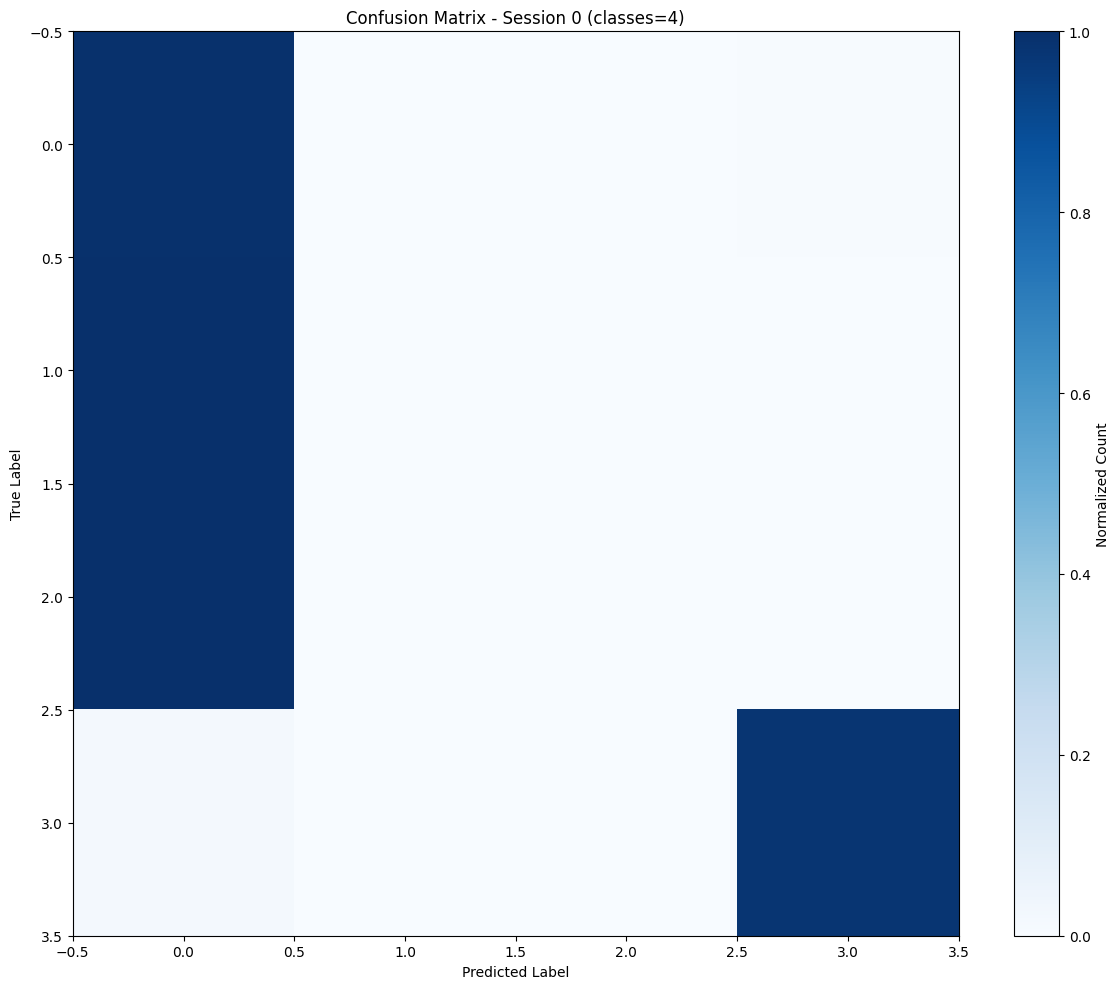

In [30]:
# 評価（簡易 + 混同行列）
from utils import count_acc_topk
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model.eval()
vl, va, va5 = Averager(), Averager(), Averager()
all_predictions, all_labels = [], []
with torch.no_grad():
    for i, batch in enumerate(testloader, 1):
        data, labels = [_.to(device) for _ in batch]
        test_class = args.base_class + session * args.way

        if MAKE['PROJECT'] == 'fact' and session > 0:
            # 統合なし（run_confusion_analysisと一致）
            if hasattr(model, 'module'):
                logits = model.module.forpass_fc(data)[:, :test_class]
            else:
                logits = model.forpass_fc(data)[:, :test_class]
        else:
            logits = model(data)[:, :test_class]

        loss = F.cross_entropy(logits, labels)
        acc = count_acc(logits, labels)
        top5 = count_acc_topk(logits, labels)
        vl.add(loss.item())
        va.add(acc)
        va5.add(top5)
        preds = torch.argmax(logits, dim=1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print('eval: loss=', vl.item(), 'acc=', va.item(), 'acc@5=', va5.item())

# 混同行列（行正規化）を作成して表示
cm = confusion_matrix(all_labels, all_predictions, normalize='true')
plt.figure(figsize=(12, 10))
plt.imshow(cm, cmap='Blues', aspect='auto')
plt.colorbar(label='Normalized Count')
plt.title(f'Confusion Matrix - Session {session} (classes={test_class})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 必要ならファイル保存
os.makedirs('confusion_analysis_inline', exist_ok=True)
plt.imsave(os.path.join('confusion_analysis_inline', f'cm_session_{session}.png'), cm, cmap='Blues')


In [18]:
# 最良モデル保存（手動）
import os
from copy import deepcopy

save_root = os.path.join('checkpoint', args.dataset, MAKE['PROJECT'])
if MAKE['DEBUG']:
    save_root = os.path.join('debug', save_root)
os.makedirs(save_root, exist_ok=True)

best_path = os.path.join(save_root, f'session{session}_max_acc.pth')
state = model.state_dict() if not hasattr(model, 'module') else model.module.state_dict()
import torch
torch.save(dict(params=state), best_path)
print('saved:', best_path)


saved: checkpoint/cicids2017_improved/fact/session0_max_acc.pth


In [19]:
# プロトタイプ置換（baseセッションのみ）
from models.base.helper import replace_base_fc as base_replace
from models.fact.helper import replace_base_fc as fact_replace

if session == 0:
    # test用transformを利用
    transform = getattr(testloader.dataset, 'transform', None)
    if MAKE['PROJECT'] == 'base':
        model = base_replace(train_set, transform, model, args)
    else:
        model = fact_replace(train_set, transform, model, args, device)
    state = model.state_dict() if not hasattr(model, 'module') else model.module.state_dict()
    torch.save(dict(params=state), os.path.join(save_root, f'session{session}_max_acc.pth'))
    print('prototype replaced and saved')
else:
    print('skip: not base session')


prototype replaced and saved


In [20]:
# 次セッション用FC更新（incremental用のステップ）
if session > 0:
    # 新規クラスの分類器をデータ平均で更新
    if hasattr(model, 'module'):
        model.module.update_fc(trainloader, torch.unique(torch.tensor(train_set.targets)), session)
    else:
        import numpy as np
        model.update_fc(trainloader, np.unique(train_set.targets), session)
    print('FC updated for new session:', session)
else:
    print('skip: base session')


skip: base session
